In [1]:
import pandas as pd
import numpy as np
import time
import warnings
warnings.filterwarnings('ignore')

from matplotlib import pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_validate

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix

import pickle

In [2]:
# 目标变量
target_var = 'Attrition'

# 连续变量
num_col = ['Age', 'MonthlyIncome', 'TotalWorkingYears','PercentSalaryHike',
           'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
           'YearsWithCurrManager', 'NumCompaniesWorked']
# 有序变量
ord_col = ['DistanceFromHome', 'Education', 'EnvironmentSatisfaction', 'JobInvolvement',
           'JobLevel', 'JobSatisfaction', 'PerformanceRating', 'RelationshipSatisfaction',
           'StockOptionLevel', 'WorkLifeBalance', 'TrainingTimesLastYear']

# 分类变量
cat_col = ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole',
           'MaritalStatus', 'OverTime']

In [3]:
train = pd.read_csv('pfm_train.csv', header=0)
test = pd.read_csv('pfm_test.csv', header=0)

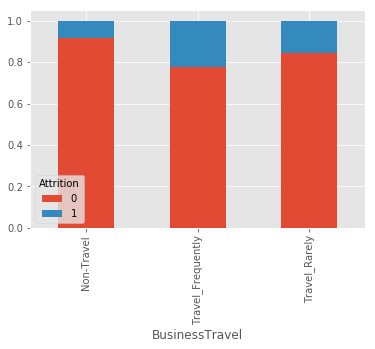

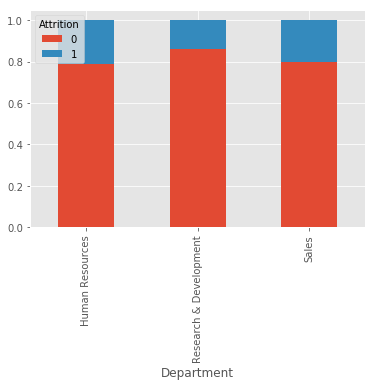

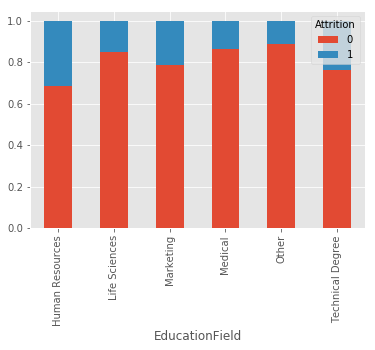

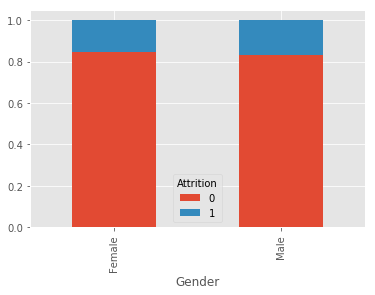

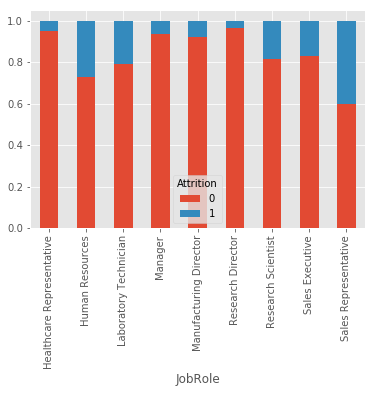

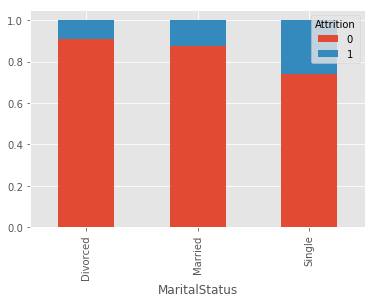

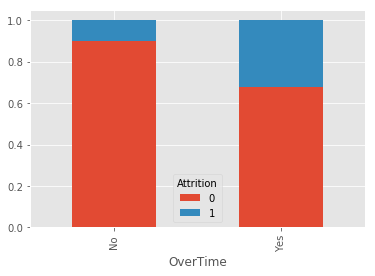

In [32]:
for col in cat_col:
    _ = plt.figure()
    table=pd.crosstab(train[col], train['Attrition'])
    table.div(table.sum(1), axis=0).plot(kind='bar', stacked=True)

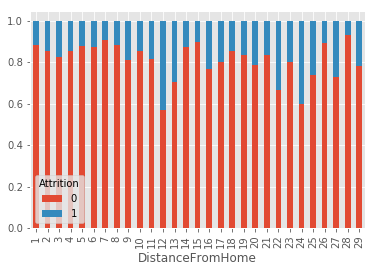

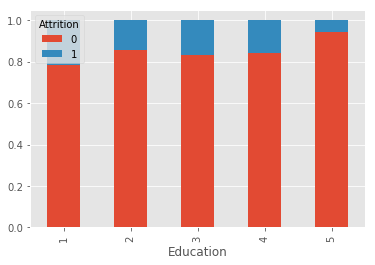

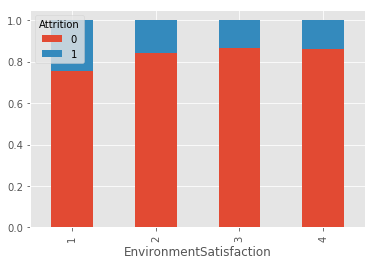

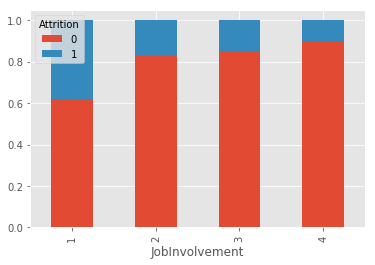

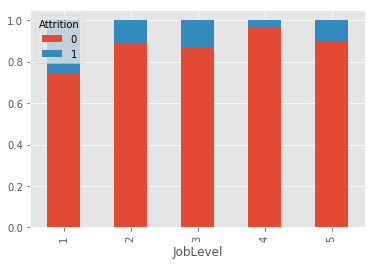

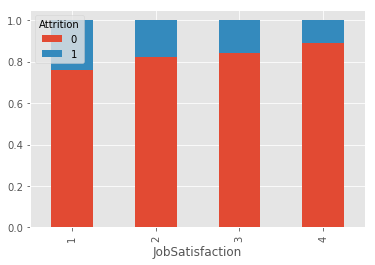

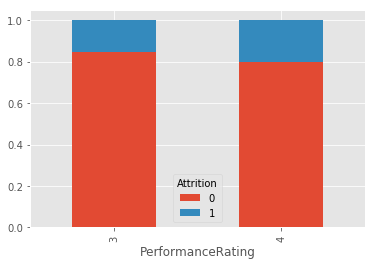

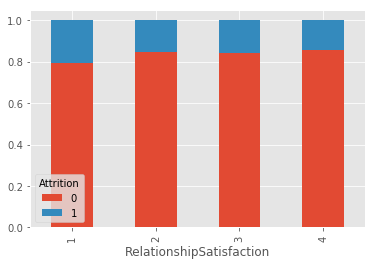

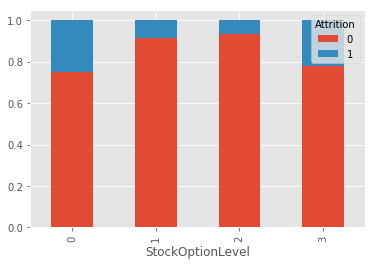

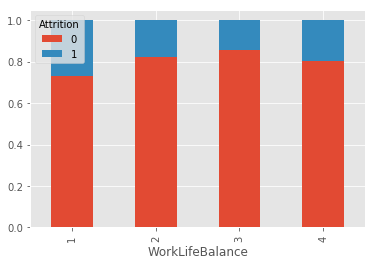

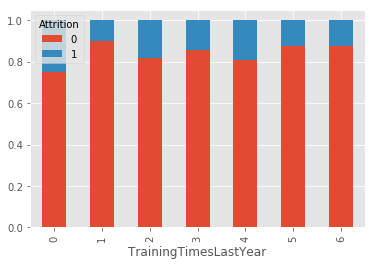

In [33]:
for col in ord_col:
    _ = plt.figure()
    table=pd.crosstab(train[col], train['Attrition'])
    table.div(table.sum(1), axis=0).plot(kind='bar', stacked=True)

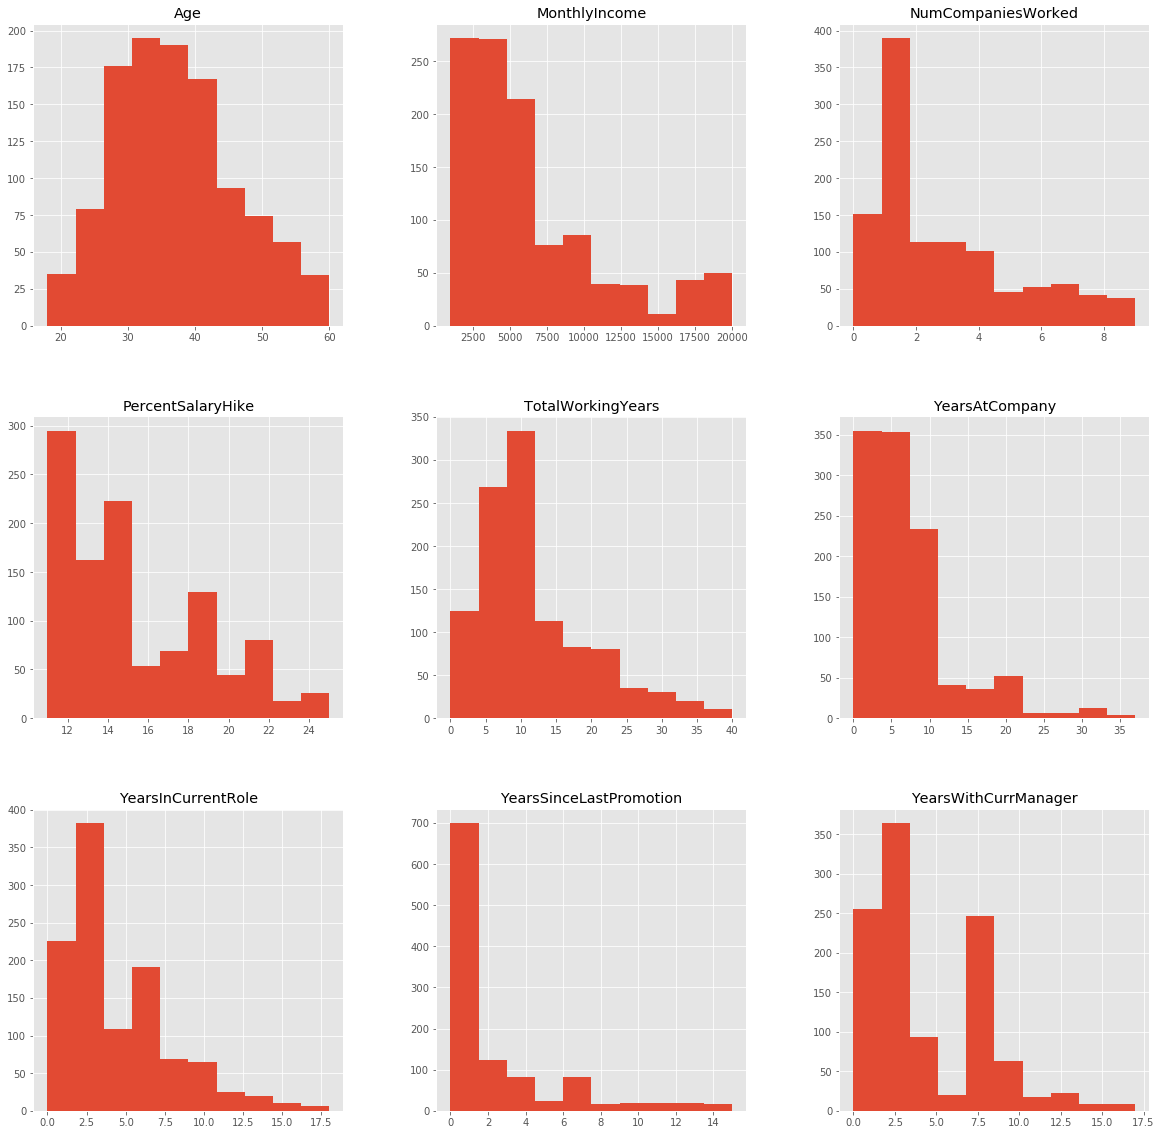

In [38]:
_ = train[num_col].hist(bins=10, figsize=(20,20))

In [4]:
for var in cat_col:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(train[var], prefix=var)
    train1=train.join(cat_list)
    train=train1
    train.drop([var], axis=1, inplace=True)

In [5]:
for var in ord_col:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(train[var], prefix=var)
    train1=train.join(cat_list)
    train=train1
    train.drop([var], axis=1, inplace=True)

In [6]:
y = train['Attrition']
X = train.drop(['Over18', 'EmployeeNumber', 'StandardHours'], axis=1)
cols = [x for x in X.columns if x != 'Attrition']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X[cols], y, test_size=0.3, random_state=0)

In [15]:
class LR(LogisticRegression):
    def __init__(self, threshold=0.01, dual=False, tol=1e-4, C=1.0,
                 fit_intercept=True, intercept_scaling=1, class_weight=None,
                 random_state=None, solver='liblinear', max_iter=100,
                 multi_class='ovr', verbose=0, warm_start=False, n_jobs=1):
        # 权值相近的阈值
        self.threshold = threshold
        LogisticRegression.__init__(self, penalty='l1', dual=dual, tol=tol, C=C,
                 fit_intercept=fit_intercept, intercept_scaling=intercept_scaling, class_weight=class_weight,
                 random_state=random_state, solver=solver, max_iter=max_iter,
                 multi_class=multi_class, verbose=verbose, warm_start=warm_start, n_jobs=n_jobs)
        #使用同样的参数创建L2逻辑回归
        self.l2 = LogisticRegression(penalty='l2', dual=dual, tol=tol, C=C,
                                                                    fit_intercept=fit_intercept, intercept_scaling=intercept_scaling,
                                                                    class_weight = class_weight, random_state=random_state, solver=solver,
                                                                    max_iter=max_iter, multi_class=multi_class, verbose=verbose,
                                                                    warm_start=warm_start, n_jobs=n_jobs)
    def fit(self, X, y, sample_weight=None):
        #训练L1逻辑回归
        super(LR, self).fit(X, y, sample_weight=sample_weight)
        self.coef_old_ = self.coef_.copy()
        #训练L2逻辑回归
        self.l2.fit(X, y, sample_weight=sample_weight)
        cntOfRow, cntOfCol = self.coef_.shape
        #权值系数矩阵的行数对应目标值的种类数目
        for i in range(cntOfRow):
            for j in range(cntOfCol):
                coef = self.coef_[i][j]
                #L1逻辑回归的权值系数不为0
                if coef != 0:
                    idx = [j]
                    #对应在L2逻辑回归中的权值系数
                    coef1 = self.l2.coef_[i][j]
                    for k in range(cntOfCol):
                        coef2 = self.l2.coef_[i][k]
                        #在L2逻辑回归中，权值系数之差小于设定的阈值，且在L1中对应的权值为0
                        if abs(coef1-coef2) < self.threshold and j != k and self.coef_[i][k] == 0:
                            idx.append(k)
                    #计算这一类特征的权值系数均值
                    mean = coef / len(idx)
                    self.coef_[i][idx] = mean
        return self


In [16]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(random_state=45, penalty='l1')
select = SelectFromModel(LR(threshold=0.5, C=0.1))
new = select.fit_transform(X_train, y_train)
# for i in range(1, len(cols)+1):
#     rfe = RFE(model, i)
#     new = rfe.fit_transform(X_train, y_train)
#     model.fit(new, y_train)
#     test = rfe.transform(X_test)
#     score = model.score(test, y_test)
#     print('{}, score:{:.3f}'.format(i,score))
#rfe_result = pd.DataFrame({'support':rfe.support_, 'ranking':rfe.ranking_, 'cols': cols})

In [51]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logreg = LogisticRegression(random_state=45, penalty='l2', C=0.1)
logreg.fit(new, y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=45, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [52]:
from sklearn.metrics import accuracy_score
test = select.transform(X_test)
print('Logistic regression accuracy: {:.3f}'.format(accuracy_score(y_test, logreg.predict(test))))

Logistic regression accuracy: 0.891


In [38]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(new, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [14]:
print('Random Forest Accuracy: {:.3f}'.format(accuracy_score(y_test, rf.predict(test))))

Random Forest Accuracy: 0.867


In [117]:
from sklearn.svm import SVC
svc = SVC()
svc.fit(X_train[useful_col], y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [118]:
print('Support vector machine accuracy: {:.3f}'.format(accuracy_score(y_test, svc.predict(X_test[useful_col]))))

Support vector machine accuracy: 0.855


In [120]:
from sklearn.metrics import classification_report
print(classification_report(y_test, logreg.predict(X_test[useful_col])))

             precision    recall  f1-score   support

          0       0.91      0.97      0.94       282
          1       0.71      0.42      0.53        48

avg / total       0.88      0.89      0.88       330

